In [1]:
import numpy as np
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

np.random.seed(2)



data = scipy.io.loadmat('PAMAP2.mat')
Xy_train0 = data['Xy_train']
Xy_test0 = data['Xy_test']


print('including MLP/CNN/LSTM/ConvLSTM')




including MLP/CNN/LSTM/ConvLSTM


In [2]:
print('in DL, it is crucial to perform channel-wise normalisation')
mn = np.mean(Xy_train0[:,:-1], axis=0)
#print(mn.shape)
std = np.std(Xy_train0[:,:-1], axis=0)
#print(std.shape)
Xy_train0[:,:-1] = (Xy_train0[:,:-1]-mn)/std
Xy_test0[:,:-1] = (Xy_test0[:,:-1]-mn)/std

in DL, it is crucial to perform channel-wise normalisation


In [3]:
cNum=12
win_len = 100
dim = Xy_train0.shape[1]-1 #minus the label col
print(dim)

27


In [4]:
def sliding_window(Xy, percentage=0.5, win_len=100):
    #print('per')
    print('overlapping_percentage:  '+str(percentage*100)+'%')

    batch_size0 = int(np.floor(len(Xy)/win_len))
    #print(batch_size0)
    Xy0 = Xy[:win_len*batch_size0,:]
    if percentage==1:
        print('100% overlapping means no overlapping')
        return Xy0

    K_fold = int(1/(1-percentage))
    #print(K_fold)
    offset = int(np.round(win_len * (1-percentage)))
    Xy_big = []
    for k in range(K_fold):
        #print(k)
        current_set = Xy0[k*offset:len(Xy0)-(win_len-k*offset),:]
        #print(len(current_set))
        Xy_big.append(current_set)
    return np.concatenate(Xy_big)

def _to_frames(Xy, dim, win_len=100):
    X3D = np.reshape(Xy[:,:-1], (-1, win_len, dim))
    y2D = np.reshape(Xy[:,-1],(-1, win_len)).astype(int)
    y = np.zeros(len(y2D))
    for i in range(len(y2D)):
        counts = np.bincount(np.reshape(y2D[i, :], (-1)))
        y[i] = np.argmax(counts)
    return X3D, y

In [5]:



print(Xy_train0.shape)
Xy_train = sliding_window(Xy_train0, 0.5, win_len)
print(Xy_train.shape)
X_train0, y_train0 = _to_frames(Xy_train,dim, win_len)


print(Xy_test0.shape)
Xy_test = sliding_window(Xy_test0, 0.5, win_len)
print(Xy_test.shape)
X_test0, y_test0 = _to_frames(Xy_test,dim,win_len)




(473445, 28)
overlapping_percentage:  50.0%
(946600, 28)
(174180, 28)
overlapping_percentage:  50.0%
(348000, 28)


In [6]:
Xy_train.shape

(946600, 28)

class 0, sample number 275, percentage 2.9%
class 1, sample number 971, percentage 10.3%
class 2, sample number 902, percentage 9.5%
class 3, sample number 957, percentage 10.1%
class 4, sample number 1205, percentage 12.7%
class 5, sample number 337, percentage 3.6%
class 6, sample number 797, percentage 8.4%
class 7, sample number 901, percentage 9.5%
class 8, sample number 596, percentage 6.3%
class 9, sample number 540, percentage 5.7%
class 10, sample number 867, percentage 9.2%
class 11, sample number 1118, percentage 11.8%


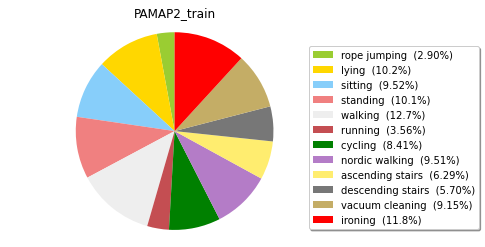

class 0, sample number 50, percentage 1.4%
class 1, sample number 313, percentage 9.0%
class 2, sample number 333, percentage 9.6%
class 3, sample number 309, percentage 8.9%
class 4, sample number 384, percentage 11.0%
class 5, sample number 317, percentage 9.1%
class 6, sample number 301, percentage 8.6%
class 7, sample number 353, percentage 10.1%
class 8, sample number 183, percentage 5.3%
class 9, sample number 161, percentage 4.6%
class 10, sample number 303, percentage 8.7%
class 11, sample number 473, percentage 13.6%


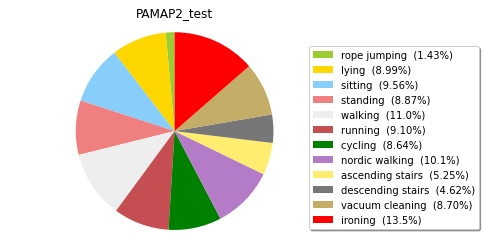

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
def drawing_pie_chart(percentages, labels, dataset_id):
    plt.title(dataset_id)
    color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
            '#eeeeee','#C44E52', 'green', '#B47CC7','#ffed6f','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]
    
    labels = labels.copy()
    for i in range(len(percentages)):
        labels[i] = labels[i]+'  ('+str(percentages[i])[:4]+'%)'
    colors = color_set[:len(percentages)]
    
    
    patches, texts = plt.pie(percentages, colors=colors, startangle=90)
    
    plt.axis('equal')
    lgd = plt.legend(labels, loc=(0.9, 0.05), shadow=True, borderaxespad=10.)
    
    
    #plt.savefig('dataset_'+dataset_id+'.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=600)
    plt.show()
    
def calculating_percentages(y_, cNum):
    percentages = np.zeros(cNum)
    for i in range(cNum):
        num = np.sum(y_==i)
        percentages[i]=100.0*num/len(y_)
        print('class {}, sample number {}, percentage {:.1f}%'.format(i, num, percentages[i]))
    return percentages


dataset_id = 'PAMAP2'
labels_PAMAP2 = [r'rope jumping', 
                 r'lying', 
                 r'sitting', 
                 r'standing',
                 r'walking', 
                 r'running', 
                 r'cycling', 
                 r'nordic walking',
                 r'ascending stairs', 
                 r'descending stairs', 
                 r'vacuum cleaning', 
                 r'ironing']
cNum = 12 # 12 classes for PAMAP2


percentages_train = calculating_percentages(y_train0, cNum)
drawing_pie_chart(percentages_train,labels_PAMAP2,dataset_id+'_train')


percentages_test = calculating_percentages(y_test0, cNum)
drawing_pie_chart(percentages_test,labels_PAMAP2,dataset_id+'_test')

In [8]:

def _reshaping_Network_input(X, network_type):
    _, win_len, dim = X.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X = np.swapaxes(X,1,2)
        X = np.reshape(X, (-1, dim, win_len, 1))
                
    if network_type=='MLP':
        #print('MLP...')
        X = np.reshape(X, (-1, dim*win_len))

    return X

In [9]:

def model_variant(model, num_feat_map, dim, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(0.5))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))

        
def model_conv(model, num_feat_map):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_LSTM(model):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(0.5))

def model_MLP(model, num_hidden_mlp):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(0.5))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(0.5))
    
def model_output(model):
    model.add(Dense(cNum, activation='softmax'))

In [22]:

batch_size = 128
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'MLP'
#network_type = 'CNN'
#network_type = 'LSTM'
network_type = 'ConvLSTM'


_, win_len, dim = X_train0.shape


In [23]:
X_train = _reshaping_Network_input(X_train0, network_type)
X_test = _reshaping_Network_input(X_test0, network_type)
print(X_train.shape)

ConvLSTM
ConvLSTM
(9466, 27, 100, 1)


In [24]:
print('one hot encoding for the labels')
y_train = keras.utils.to_categorical(y_train0, cNum)

one hot encoding for the labels


In [25]:


print('building the model ... ')
model = Sequential()


if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 
    
    
    
    
model_output(model)    
model.summary()



building the model ... 
ConvLSTM
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 27, 100, 16)       96        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 27, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 50, 16)        1296      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 25, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout) 

In [26]:


epochs = 5

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True)

Epoch 1/5
74/74 [==============================] - 4s 51ms/step - loss: 1.4706 - accuracy: 0.5620
Epoch 2/5
74/74 [==============================] - 4s 50ms/step - loss: 0.7216 - accuracy: 0.8054
Epoch 3/5
74/74 [==============================] - 4s 50ms/step - loss: 0.5112 - accuracy: 0.8752
Epoch 4/5
74/74 [==============================] - 4s 50ms/step - loss: 0.4102 - accuracy: 0.9038
Epoch 5/5
74/74 [==============================] - 4s 51ms/step - loss: 0.3512 - accuracy: 0.9178


In [27]:

from time import time
from sklearn.metrics import accuracy_score, f1_score
t0 = time()
y_pred = np.argmax(model.predict(X_test), axis=1)
print(str((time()-t0)*1000/len(y_pred))+' ms/frame')
y_test = y_test0.copy()
mean_f1 = f1_score(y_test, y_pred, average='macro')  
weighted_f1 = f1_score(y_test, y_pred, average='weighted') 
acc = accuracy_score(y_test, y_pred)
print(network_type+'     mean-f1: {:.2f}, weighted-f1: {:.2f}, acc: {:.2f}'.format(mean_f1, weighted_f1, acc))


    

109/109 [==============================] - 1s 7ms/step
0.2649476473358856 ms/frame
ConvLSTM     mean-f1: 0.86, weighted-f1: 0.87, acc: 0.87
